**Video:** [YouTube: https://youtu.be/E8oyZAwGyH8](https://youtu.be/E8oyZAwGyH8)

# COGS 108 - Is Retail Therapy Real? A Study on the Relationship between Mental Health and Consumerist Holidays. 

## Permissions

Place an `X` in the appropriate bracket below to specify if you would like your group's project to be made available to the public. (Note that student names will be included (but PIDs will be scraped from any groups who include their PIDs).

* [X] YES - make available
* [  ] NO - keep private

# Overview

Each year, around the holidays, people tend to spend more money buying gifts and other things for themselves and their loved ones. We were inspired by a common notion known as "retail therapy", where making purchases is said to improve mental health. Looking to investigate the validity of this claim, we did our research on mental health in relation to common consumerist holidays. We decided to conduct our analysis on it in a few ways. We sought to determine if there was a relationship in days that had high interest in consumerist ideas in two ways - primarily those associated with certain consumerist days in the United States, as well as a pure correlation between search interest in terms that are related to negative mental health with search terms that are associated with consumerism. While far from a perfect predictor, there does indeed appear to be a significant negative relationship between search interest in terms related to mental health and those related to consumerism.

# Names

- Nishant Balaji
- Connor Betterly 
- Matei Gardus
- Tristan Tjan
- Aaron Yu

<a id='research_question'></a>
# Research Question

### *Is there a statistically significant decrease in Google searches relating to negative mental health in the days before and after periods where consumerism is encouraged?*
- Negative mental health-related searches include keywords such as:
    - "mental health"
    - "suicide"
    - "anxiety"
    - "anxious"
    - "stress"
    - "burnout"
    - "depression"
    - "therapy"
    - "trauma"
- Periods where consumerism is encouraged include:
    - Black Friday
    - Amazon Prime Day
    - Cyber Monday
    - Christmas
    - Mother's Day
    - Father's Day
    - Easter
    - The Fourth of July
    - The Super Bowl

Note that we did leave out certain days - Valentine's Day is associated as much with the idea of love as consumerism, and Halloween would see an increase in costumes, candy, and pumpkin (spice) purchases largely on the day as well, and not as much just before the day itself.

<a id='background'></a>

## Background & Prior Work

"Retail Therapy" (1) is a relatively recent term, with its first known published use in the *Chicago Tribune* on Christmas Eve of 1986 (2). It has picked up increasing popularity due to the apparent allure of purchasing items to counteract mental stressors. 

Anecdotally, many of the friends of our group have reported that buying merchandise seems to help them fare better throughout trying times, and as such, we considered the idea of "Retail Therapy" being a real phenomenon.

Previous research and work regarding "retail therapy" seems to indicate that mental health is at least somewhat positively correlated with consumerism, as illustrated by some of the studies we have found (3, 4). However, most of the studies we have found seem to take an experimental approach rather than a data-driven one. While this is a solid ground for us to build on, and thus at least demonstrating the potential existence of such a phenomenon, we considered that there are more insights to be gained with regard to this phenomenon, notably with a focus on how much "retail therapy" can affect us, and also looking more into "retail therapy" staving off negative mental health.

While "retail therapy" can be something anyone can do at any time of year, there are particular times of the year which have, through time and happenstance, become culturally associated with consumerism across the population of the United States (along with other countries). This can include a wide spectrum of events, whether it be days that are specifically consumerist, such as Amazon's Prime Day, to days that have consumerist sub-tones but are not at their core consumerist, such as Christmas, which is originally religious more than consumerist in its theme. Regardless, it is hard to deny the notion of these holidays encouraging us to purchase merchandise. Whether it be the goal of the holiday, which is the case with Prime Day's sales, or merely a tradition that is part of it, such as buying gifts for Christmas, consumerism plays an essential part in the holiday.

We were curious enough to investigate whether the effect on the population's mental health is affected enough by these days' traditions to be statistically significant.

References:
- 1) https://www.urbandictionary.com/define.php?term=Retail%20Therapy
- 2) https://en.wikipedia.org/wiki/Retail_therapy
- 3) https://deepblue.lib.umich.edu/bitstream/handle/2027.42/100258/1208_Rick_Jan14.pdf
- 4) https://myscp.onlinelibrary.wiley.com/doi/full/10.1016/j.jcps.2013.12.004

# Hypothesis


In our study, we hypothesize that there is a inverse relationship between the increased sales around days of consumerism such as  Black Friday, Amazon Prime Day, Cyber Monday, Christmas, Mother's day, Father's Day, Easter, Fourth of July and the internet traffic relating to mental health. We believe this is the case not only due to the aforementioned anecdotal evidence (see Background) but also due to the linked studies presenting a statistically significant improvement in mental health after making purchasing decisions, thus potentially causing search results to be influenced as well, which would lend more evidence corroborating the existence of the phenomenon of "Retail Therapy."

# Dataset

- Dataset Name: Google Trends
- Link to the dataset: https://trends.google.com/
- Number of observations: Google Trends has many observations; the subset we use will have 33,241 observations.

Google Trends contains a representative sample of all Google searches each day (of which there are billions), alongside their releative frequency. We plan on using the `pytrends` API to access it rather than downloading from the site itself.

While we toyed with the idea of combining this with a sentiment analysis dictionary to further analyze the negativity of each word compared to another, we ultimately decided against it.

# Setup

In [ ]:
%pip install pytrends

In [1]:
from pathlib import Path
from functools import reduce
from operator import iconcat

from pytrends.dailydata import get_daily_data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import patsy
import statsmodels.api as sm

sns.set_theme()

# Data Gathering and Cleaning

PyTrends provides a function to download daily relative search interest for a extended period of time using the function called `get_daily_data`. In order to get all of our relevant data, we will download all of the data for each individual keyword we've selected, and then concatenate all of the returned DataFrames together into one single DataFrame, upon which we'll perform most of our analyses.

Note that PyTrends won't return our ideal dataset, but we can wrangle it to match what we want. Particularly, we want a dataset such that each observation (in our case, days) has as variables
the relative search interest for each term we've selected.

Lastly, we note that Google Trends is notoriously preemptive with their rate-limiting policy, and thus, for the safety of keeping our data locally saved, we automatically save Pickle files of the originally obtained data to import later, so as to save the downloading steps. Once we have the data locally, we can progress to performing data cleaning.

We start by creating some constants used throughout the project.

In [2]:
# CONSTANTS SECTION
# These will be used throughout the project, so we'll document them here just to make them clear.

# The number of years we'll extract for our dataset.
NUM_YEARS = 7

# The set of keywords we were looking to analyze.
kw_list = ["mental health", "suicide", "stress", "anxiety", "anxious", "burnout", "depression", "therapy", "trauma", "price", "mall", "coupon", "discount"]

# The lists of dates that we're analyzing. This includes the date for each holiday we're focusing on for the past 7 years.
# The dates are in YYYY-MM-DD format.
FOURTH_OF_JULY_DATES = ['2015-07-04', '2016-07-04', '2017-07-04', '2018-07-04', '2019-07-04', '2020-07-04']
CHRISTMAS_DATES = ['2015-12-25', '2016-12-25', '2017-12-25', '2018-12-25', '2019-12-25', '2020-12-25', '2021-12-25']
SUPER_BOWL_DATES = ['2015-02-01', '2016-02-07', '2017-02-05', '2018-02-04', '2019-02-03', '2020-02-02', '2021-02-07']
FATHERS_DAY_DATES = ['2015-06-21', '2016-06-19', '2017-06-18', '2018-06-17', '2019-06-16', '2020-06-21', '2021-06-20']
MOTHERS_DAY_DATES = ['2015-05-10', '2016-05-08', '2017-05-14', '2018-05-13', '2019-05-12', '2020-05-10', '2021-05-09']
BLACK_FRIDAY_DATES = ['2015-11-27', '2016-11-25', '2017-11-24', '2018-11-23', '2019-11-29', '2020-11-27', '2021-11-26']
CYBER_MONDAY_DATES = ['2015-11-30', '2016-11-28', '2017-11-27', '2018-11-26', '2019-12-2', '2020-11-30', '2021-11-29']
EASTER_DATES = ['2015-04-05', '2016-03-27', '2017-04-16', '2018-04-01', '2019-04-21', '2020-04-12', '2021-04-04']
PRIME_DAY_DATES = ['2015-07-15', '2016-07-12', '2017-07-11', '2018-07-16', '2019-07-15', '2020-07-13', '2021-07-21']

Now, we download the individual datasets from Google Trends. We'll save each of them to Pickle files.

**WARNING:** This cell takes a long time to run! (approximately 1 hour according to our original run).
Only run this cell once, when needing to acquire the Pickle files. If the Pickle files are not on hand and time is a constraint, please use the provided Python script called `get_data.py` in order to download the data to the required directory from our Google Drive. You'll need to install `gdown` first:

```sh
pip install gdown
python get_data.py
```

In [ ]:
# FINAL WARNING: This takes one hour to run!
# Be careful! It might also fail because of rate limiting!

# Make our data directory folder.
Path("./data").mkdir(parents=True, exist_ok=True)

# Get the set of keywords we were looking to analyze.
kw_list = ["mental health", "suicide", "stress", "anxiety", "anxious", "burnout", "depression", "therapy", "trauma"]
# For each keyword, download its data and save it to a Pickle file.
for keyword in kw_list:
    # Get the original keyword's spaces replaced with underscores, if any, so the Pickle
    # file we save is not weird to write a path for.
    file_keyword = keyword.replace(" ", "_")

    # Download the daily data and save the Pickle file.
    # We're downloading from Jan 1 2015 to Jan 1 2022.
    daily_data = get_daily_data(keyword, 2015, 1, 2022, 1)
    daily_data.to_pickle(f"./data/{file_keyword}_trends.pkl")

To make EDA easier in future stages, we'll concatenate all of our downloaded data into one
singular dataset. We'll do this by taking the aforementioned saved Pickle files and putting
them all into one singular DataFrame.

Since all of our datasets share the same date index (of the same size, too!) because of our selected timerange, we'll just need to concatenate the columns.

In [3]:
full_search_trends = pd.DataFrame()

for keyword in kw_list:
    # Get the keyword file name.
    file_keyword = keyword.replace(" ", "_")

    # Get the daily data from the Pickle file.
    daily_data = pd.read_pickle(f"./data/{file_keyword}_trends.pkl")

    # There are a few columns attached to our data that
    # are related to the calculations that PyTrends does
    # to normalize data over such an extended period of time,
    # due to Google Trends limitations. Drop these columns,
    # since we don't need them.
    daily_data.drop(columns=[
        f"{keyword}_unscaled",
        f"{keyword}_monthly",
        "isPartial",
        "scale"
    ], inplace=True)

    # If this is the first keyword we've downloaded, our final
    # DataFrame starts off as empty, so we'll want to just
    # add the current DataFrame to that, with all columns but
    # f"{keyword}" removed.
    if full_search_trends.empty:
        full_search_trends = daily_data
    else:
        # Otherwise, means we need to add our new data to the already
        # existing DataFrame, at the same indices. Just concatenate
        # the accumulated DataFrame with this keyword's DataFrame.
        full_search_trends = pd.concat([full_search_trends, daily_data], axis=1)

# Also add averages of each category for each observation.
full_search_trends['avg_neg_mental_health'] = full_search_trends[['mental health', 'suicide', 'stress', 
        'anxiety', 'anxious', 'burnout', 'depression', 'therapy', 'trauma']].mean(axis = 1)

full_search_trends['avg_consumerism'] = full_search_trends[['price', 'mall', 'coupon', 'discount']].mean(axis = 1)

full_search_trends.head()

,mental health,suicide,stress,anxiety,anxious,burnout,depression,therapy,trauma,price,mall,coupon,discount,avg_neg_mental_health,avg_consumerism
date,,,,,,,,,,,,,,,
2015-01-01,14.28,12.58,23.76,32.48,31.68,55.00,37.96,31.92,12.88,45.08,58.00,49.68,66.42,28.060000,54.7950
2015-01-02,23.46,11.22,31.68,41.18,26.28,26.40,40.15,53.96,30.82,45.57,32.48,66.96,81.00,31.683333,56.5025
2015-01-03,19.38,12.92,32.40,35.96,18.00,50.05,49.64,38.76,30.36,46.06,31.90,72.00,79.38,31.941111,57.3350
2015-01-04,23.97,9.69,32.40,43.50,32.76,25.30,52.56,46.36,21.16,41.16,30.16,61.20,71.28,31.966667,50.9500
2015-01-05,41.31,8.67,42.48,52.78,36.00,37.95,62.05,69.92,16.56,43.61,15.08,50.40,70.47,40.857778,44.8900


# Data Analysis & Results

We will begin our analysis by exploring our dataset more closely. We will then continue by running some statistical tests on the data in order to infer any potential statistical relationships.

# Exploratory Data Analysis (EDA)

For our Exploratory Data Analysis, we will first look at the distribution of our dataset. Next we will establish some boilerplate code to make plots easier and more readable. Then, we will comment on our findings.

## Data Distribution

Let's look at our dataset first:

In [4]:
search_trends = full_search_trends
search_trends.describe()

,mental health,suicide,stress,anxiety,anxious,burnout,depression,therapy,trauma,price,mall,coupon,discount,avg_neg_mental_health,avg_consumerism
count,2588.000000,2588.000000,2588.000000,2588.000000,2588.000000,2588.000000,2588.000000,2588.000000,2588.000000,2588.000000,2588.000000,2588.000000,2588.000000,2588.000000,2588.000000
mean,50.222249,13.900386,65.360603,70.043679,40.230004,39.185730,60.321484,64.590317,51.592152,53.468304,29.897461,44.731298,73.824602,50.605178,50.480416
std,17.540701,6.218967,14.153270,13.725257,15.705320,14.045196,13.589140,16.084889,15.247271,8.353657,13.507939,12.647766,9.472563,9.616859,7.136262
min,8.840000,3.410000,23.760000,30.150000,2.590000,0.000000,21.760000,18.200000,11.960000,30.360000,6.660000,11.660000,27.600000,24.301111,19.167500
25%,37.780000,10.647500,55.015000,60.022500,28.560000,28.955000,50.400000,49.865000,40.320000,47.700000,19.935000,35.200000,68.040000,43.653333,45.388750
50%,50.020000,13.440000,65.450000,70.550000,38.940000,38.205000,59.640000,67.860000,50.760000,51.620000,26.880000,43.740000,73.870000,50.571111,50.248750
75%,63.095000,16.000000,75.680000,80.967500,50.250000,48.300000,70.000000,77.400000,62.320000,57.010000,37.707500,52.830000,80.750000,58.231944,55.378750
max,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,72.951111,76.687500


We first observe a couple of interesting insights:

- The most volatile search term, on average, is "suicide". This is noticeable due to the fact that the 75% percentile of relative search interest for "suicide" is much lower than the maximum. This may be due to the fact that individual high-profile situations relating to "suicide" may cause the term to "spike" outside of unexpected levels.
- The most consistent search term is "anxiety". This is because 25th percentile for "anxiety" is very high and close to the mean, suggesting our data is reasonably uniform. It's interesting the mean for "anxiety" is so high as well; the fact that interest averages at 70% suggests consistently high rates of search over this period of time.'

## Plotting Code

We will continue by investigating the general search interest of all of our terms around a specific holiday.

We will do so by using a line plot graphing the interest in the 15 days before and after each of our holidays for each of our selected terms. Note that, because some of our holidays are relative in terms of the date of the year they fall on, we will normalize all of the days in our plot to indicate the relative time around the holiday; in other words, we will have our days indexed as -15, -14, ..., 14, 15. We will also average out relative interest of each individual term across all 7 years.

We will begin by first creating the functions to get the subset of our data with such normalized dates, then we'll also make a function that plots our subset.

In [5]:
# Create a subset of our data where each observation includes the average search interest relative to the original day passed to the function for the
# 6 years in our dataset. 
def extract_days_around_date(date):
    # By default, we will get the 15 days before and after the original day we are given from the function.
    date_range = pd.date_range(start = pd.to_datetime(date) - pd.Timedelta('15 day'), 
                               end = pd.to_datetime(date) + pd.Timedelta('15 day'))
    trends_around_day = search_trends.loc[date_range]

    # Set the index to represent the relative position of our date surrounding the original date.
    # We basically want -15, -14, ..., -1, 0, 1, ..., 14, 15.
    trends_around_day.set_index(pd.Series(np.arange(-15, 16, 1)), inplace=True)
    return trends_around_day

# Get the average search interest of a holiday for our dataset.
#
# "dates" is a list of dates in which our one holiday resides across all 7 years. This may or may not
# be the same calendar date.
def get_average_interest_for_holiday(dates):
    average_interest = pd.DataFrame()
    
    # Go through all NUM_YEARS dates...
    for date in dates:
        surrounding_interest = extract_days_around_date(date)
        # Add the amount for each observation.
        if average_interest.empty:
            average_interest = surrounding_interest
        else:
            average_interest = average_interest + surrounding_interest

    # Average it all out by the number of years.
    return average_interest / len(dates)

# Plot a particular holiday's interests.
def see_average_interest_for_holiday(dates, holiday_name):
    average_interest = get_average_interest_for_holiday(dates)

    # We'll make a lineplot representing our days.
    fig = sns.lineplot(data=average_interest)
    # We will also add the legend
    # outside of the graph, to the right side.
    fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    # We'll also add a line showing where the holiday is, since this makes it clearer around which
    # area we hope to see a dip. average_interest.max().max()/.min().min() return the biggest and smallest
    # search interest across the entire DataFrame.
    plt.plot([0,0], [average_interest.max().max(), average_interest.min().min()], linewidth=1.5, color='grey')
    plt.xlabel('Number of days before/after ' + holiday_name)
    plt.ylabel('Average Interest')
    plt.title("Average interest of search terms around " + holiday_name)
    plt.show()

# Plot the interest for a holiday during a particular year.
#
# Contrary to the previous function, this does not average the results, only keeps
# one year's worth of interest data.
def see_interest_in_holiday_at_year(date, holiday_name):
    specific_interest = get_average_interest_for_holiday([date]) #* NUM_YEARS @matei why was numyears multiplied here?

    # We'll make a lineplot representing our days.
    fig = sns.lineplot(data=specific_interest)
    # We will also add the legend
    # outside of the graph, to the right side.
    fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    # We'll also add a line showing where the holiday is, since this makes it clearer around which
    # area we hope to see a dip. average_interest.max().max()/.min().min() return the biggest and smallest
    # search interest across the entire DataFrame.
    plt.plot([0,0], [specific_interest.max().max(), specific_interest.min().min()], linewidth=1.5, color='grey')
    plt.xlabel('Number of days before/after ' + holiday_name)
    plt.ylabel('Average Interest')
    plt.title("Average interest of search terms around " + holiday_name)
    plt.show()


## Holiday Analysis

Now that we've written our plotting code, we will now analyze the relative search interest, on average, across our 7 years for each holiday surrounding the 15 days before or after the holiday. We will infer more accurate modeling later, but for now we are interested to see if our hypothesis is even observable at a intuitive level. We will analyze each holiday in no particular order.

### 4th of July

4th of July was a holiday we considered in our research question due to the various purchases that are made during the holiday, due to its special occasion, such as barbecues and other party products.

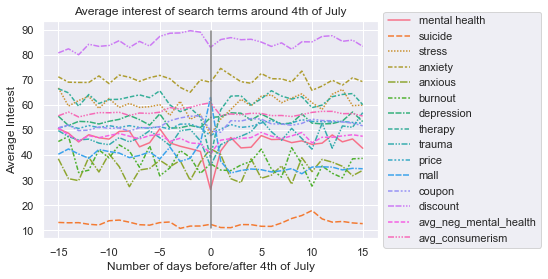

In [6]:
see_average_interest_for_holiday(FOURTH_OF_JULY_DATES, "4th of July")

We can clearly see that, at least for some terms, the average search interest has a clear dip. "Mental health" seems to have the most noticeable dip in search interest, which is intriguing. Note that "anxiety", "suicide" and "depression" don't seem to be affected. It is intriguing, however, that "anxious" goes up during the 4th of July. Perhaps this might not have to do with mental health at all; potentially, the fireworks fired during the 4th of July may trigger anxiety in some people or even animals, and this may be a cause for the search term's sudden spike in interest. However, most do seems to trend downwards surrounding the holiday.

### Christmas

Christmas is a time of joy for many around the US, notably due to the various gifts being bought for friends and family. Additionally, in recent years, it's possible the proliferation of more generic gifts have increased people interest in consumerism, such as gift cards and the tradition of providing the receipt for returns of the gifts.

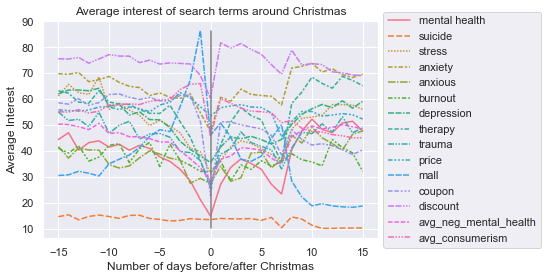

In [7]:
see_average_interest_for_holiday(CHRISTMAS_DATES, "Christmas")

There is also a clear dip of search interest across all terms except "suicide" on Christmas. We can also observe at 7 days after Christmas, which is New Year's Day. This can indicate a confounding factor in our hypothesis, notably the general increase in happiness around the holidays, and thus the lack of thoughts about problems that may lead to impaired mental health. Another vaguely comedic insight is that all of our search terms peak after New Year's, suggesting people remind themselves of the stresses in their life after the holidays.

### Super Bowl

The Super Bowl is a day with a significant amount of advertisements displayed during it and surrounding it, which may increase people's desire to engage in consumerism.

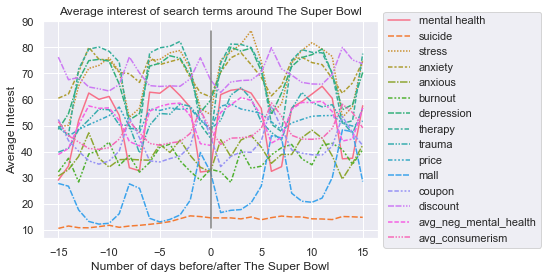

In [8]:
see_average_interest_for_holiday(SUPER_BOWL_DATES, "The Super Bowl")

While there is a clear dip during the Super Bowl, we also notice something even more unexpected; the dips are reasonably consistent every 7 days. This seems to suggest that perhaps individuals are less likely to search mental health terms during weekends, likely due to the free time. Therefore, there is no immediately obvious reduction in mental health searches due to the Super Bowl.

### Father's Day

Father's Day is a holiday that is not as universal as the others in the US, but definitely with a factor of consumerist encouragement involved, in the forms of gifts to our fathers.

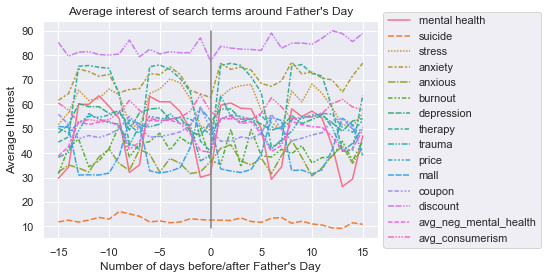

In [9]:
see_average_interest_for_holiday(FATHERS_DAY_DATES, "Father's Day")

Surprisingly, the "cycle" of dips repeats around the weekends, even for Father's Day. Perhaps the days of the week being a confounding factor is significant after all.

### Mother's Day

Mother's Day also shares a similar motive as Father's Day.

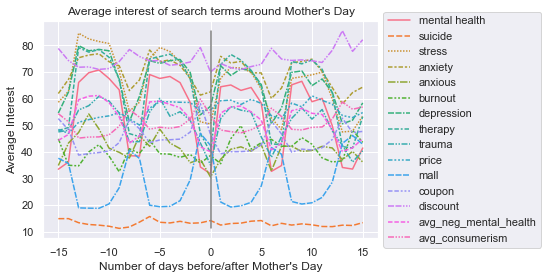

In [10]:
see_average_interest_for_holiday(MOTHERS_DAY_DATES, "Mother's Day")

Similarly to Father's Day, the week cycle seems to be a confounding factor. Perhaps there may be some other way in the future to clearly observe the issue of consumerism around the holidays, perhaps with more data.

### Black Friday

The original consumerist holiday, Black Friday is almost exclusively associated with consumerism, and glorified by the numerous sales across effectively all retailers during that time.

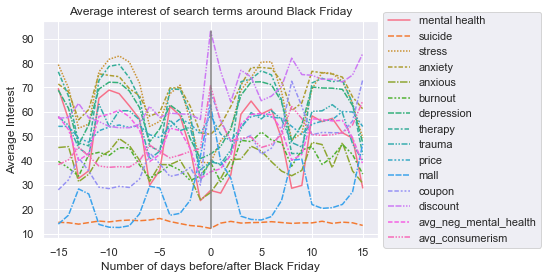

In [11]:
see_average_interest_for_holiday(BLACK_FRIDAY_DATES, "Black Friday")

The dip here of search term interest does seem to be larger, likely due to Thanksgiving being so close by, it being also a holiday.

### Cyber Monday

Similar to Black Friday, Cyber Monday continues to encourage consumerism, albeit on a different target demographic; those interested in technology.

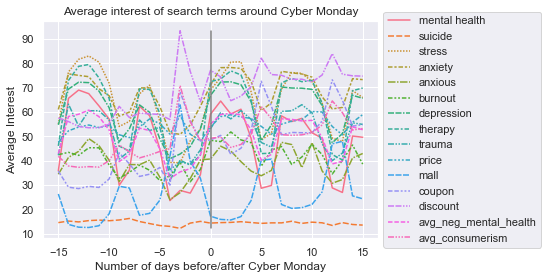

In [12]:
see_average_interest_for_holiday(CYBER_MONDAY_DATES, "Cyber Monday")

Cyber Monday shares a nearly identical graph with Black Friday, simply due to the relative indices being shifted to match Cyber Monday. However, the dip continues to remain consisten with the week cycle, albeit with a reasonably larger spike afterwards, likely due to the end of the long weekend.

### Easter

Easter is a religious holiday with similar connotations to Christmas; note however, that Easter, unlike Christmas, is not necessarily universally celebrated in the US, notably due to the lack of a federal holiday as well as the fact that not _all_ holidays for all religions necessarily converge around Easter, not even in Christian sects; even Orthodox and Christian Easters almost never overlap.

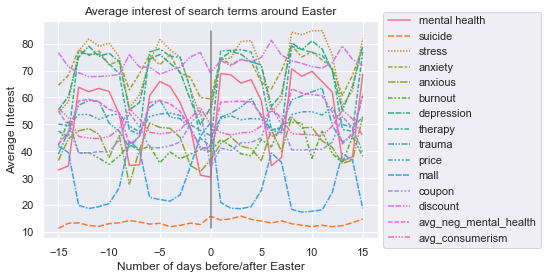

In [13]:
see_average_interest_for_holiday(EASTER_DATES, "Easter")

Easter continues to share the same "week cycle" pattern we notice in the rest of our data, likely due to it also landing on a Sunday.

### Amazon Prime Day

Prime Day is a day that is completely associated with consumerism, effectively a giant marketing campaign by Amazon to sell products using their Prime subscription.

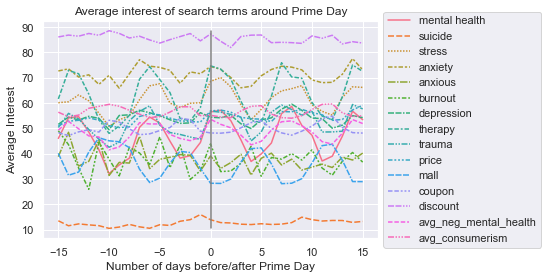

In [14]:
see_average_interest_for_holiday(PRIME_DAY_DATES, "Prime Day")

Prime Day, most surprisingly, seems to have a spike in search term interest across almost all terms. This is completely against our hypothesis, seemingly indicating that periods that encourage consumerism actually induce stress rather than reduce it.

Notably, however, Prime Day does change year after year; Amazon has either changed the period of time during which it runs as well as the discount amount. Additionally, Prime Day has become more and more popular over time, as opposed to most of our other holidays, which are already well-established.

We are curious about how the recent age of Prime Day might affect results, so we opt to analyze Prime Day specifically during each year.

### Prime Day Per Year

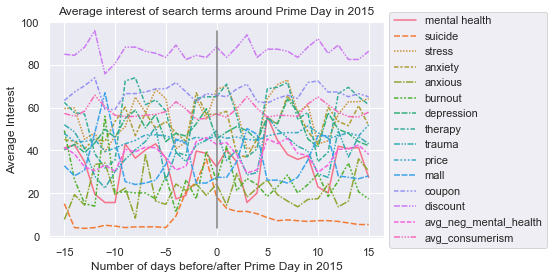

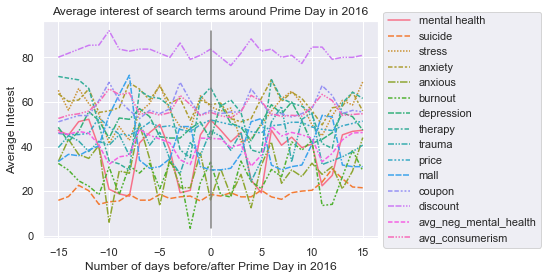

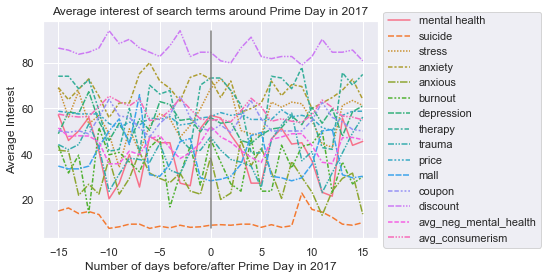

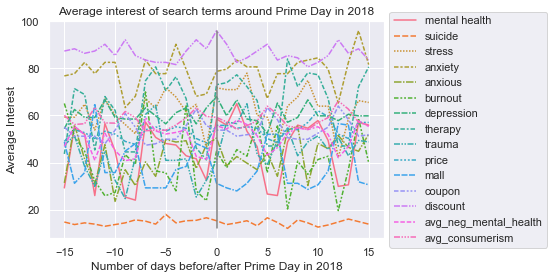

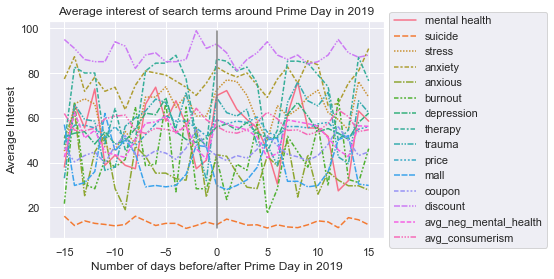

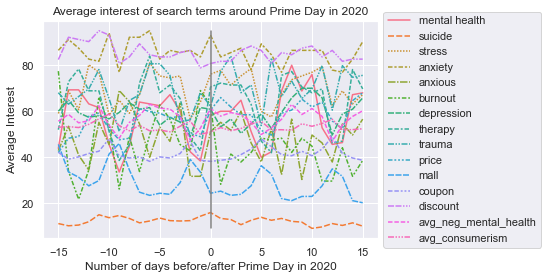

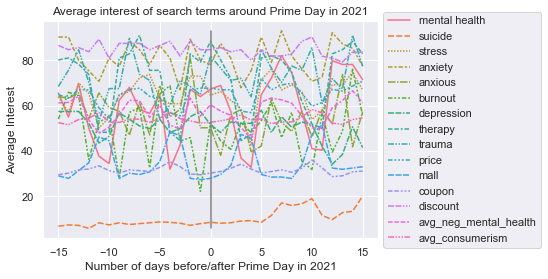

In [15]:
see_interest_in_holiday_at_year('2015-07-15', "Prime Day in 2015")
see_interest_in_holiday_at_year('2016-07-12', "Prime Day in 2016")
see_interest_in_holiday_at_year('2017-07-11', "Prime Day in 2017")
see_interest_in_holiday_at_year('2018-07-16', "Prime Day in 2018")
see_interest_in_holiday_at_year('2019-07-15', "Prime Day in 2019")
see_interest_in_holiday_at_year('2020-07-13', "Prime Day in 2020")
see_interest_in_holiday_at_year('2021-07-21', "Prime Day in 2021")

With the exception of the first Prime Day in 2015, almost all other seem to share a similar spike in search interest. Perhaps the novel factor of Prime Day was initially enticing to consumers, considering it as a one-time offer, potentially. However, perhaps in later years, the surging popularity caused Prime members to know of the upcoming sale, thus planning around it and potentially causing further stress in an attempt to keep an eye on the sales.

One matter of concern that continues to appear is the cyclical nature of weekdays; for most of our holidays, the data seems to vary depending on the time of week. Perhaps this is an issue with us averaging the number of years extracted with our data. Perhaps if we analyzed holidays one year at a time, we might obtain better insight in our data.

We'll also look at just a subset of our data in order to clarify our visualization a little more; we'll simply look over the average interest for "mental health" and consumerist terms, not all of the mental health-related terms.

In [16]:
search_trends = full_search_trends.filter(items=["mental health", "price", "mall", "coupon", "discount"])

### Easter for Year 2016

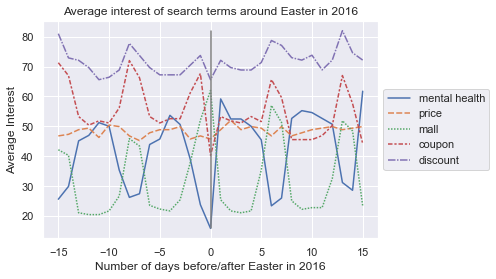

In [17]:
see_average_interest_for_holiday(['2016-03-27'], "Easter in 2016")

Looking at just one of the years, we can clearly see a decrease in mental health searches and a previous increase in the "price" term, suggesting potential last-minute purchases before Easter. This seems to reinforce our theory, despite our previous analyses.

Regardless, we'll analyze the relationship between our variables with a scatter matrix. This will include all-time data, but we're interested to see if perhaps there is a clear negative or positive relationship between our variables, regardless of dates of year.

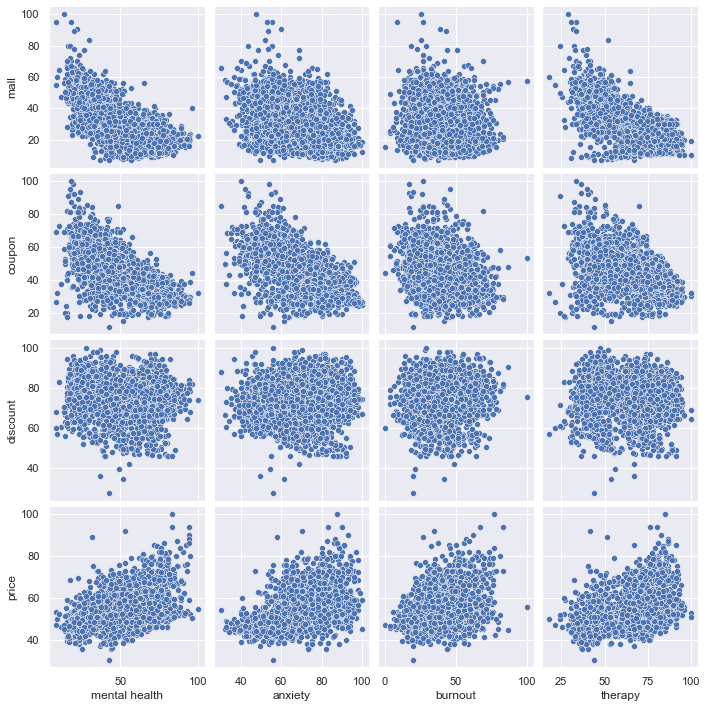

In [18]:
sns.pairplot(data=full_search_trends, x_vars=["mental health", "anxiety", "burnout", "therapy"], y_vars=["mall", "coupon", "discount", "price"])

Here, we find a weak, but visible, negative relationship between our mental-health search terms and "mall" and "coupon". Surprisingly, we find a marginally stronger positive relationship between "price" and our terms. Perhaps searching for prices increases stress rather than reducing it.

We can look more closely at a particular pair, notably between "mental health" and "coupon", to confirm the negative relationship.

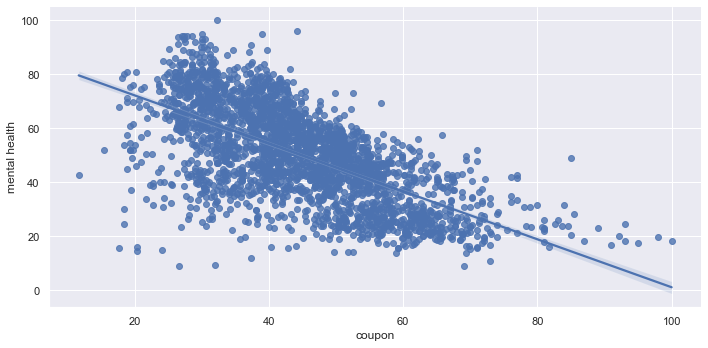

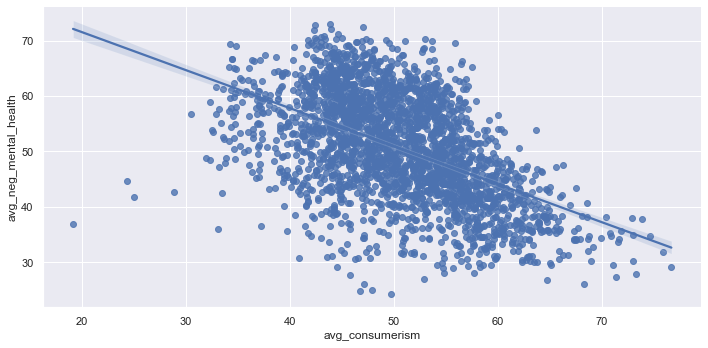

In [19]:
sns.lmplot(x="coupon",
           y="mental health",
           data = search_trends,
           aspect = 2)

# We'll also make a plot for the average search interest across
# both of our categories.
sns.lmplot(x="avg_consumerism",
           y="avg_neg_mental_health",
           data = full_search_trends,
           aspect = 2)


The negative linear relationship is visible, so perhaps a statistical test will confirm whether the relationship is statistically significant.

## Statistical Tests

We will begin by investigating whether a linear regression will yield a statistically significant relationship between "mental health" and "coupon" search term interest around our holidays. Firstly, though, we need to extract the days surrounding all of our consumerism-focused holidays. We can do this easily by taking our already defined date lists for each holiday, concatenating them and then filtering our full dataset.

In [20]:
# We'll use our previously defined method to get the 15 days surrounding all of our holidays.
# We will concatenate all of our holiday's extracted dates, together.
#
# Our extract_days_around_date returns a subset of the data, so we'll remake our date ranges here.
# We'll store all of the DateTimeIndex's we get out of our loop.
temporary_datetimeindex_array = []
for dates in FOURTH_OF_JULY_DATES, CHRISTMAS_DATES, SUPER_BOWL_DATES, FATHERS_DAY_DATES, MOTHERS_DAY_DATES, BLACK_FRIDAY_DATES, CYBER_MONDAY_DATES, EASTER_DATES, PRIME_DAY_DATES:
    for date in dates:
        date_range = pd.date_range(start = pd.to_datetime(date) - pd.Timedelta('15 day'), end = pd.to_datetime(date) + pd.Timedelta('15 day'))
        temporary_datetimeindex_array.append(date_range)

# Concatenate all of our DateTimeIndex's in one.
# Source: https://stackoverflow.com/questions/55695924/how-to-concatenate-datetimeindex-objects-in-pandas#comment120719423_55696161
dates_surrounding_holidays = temporary_datetimeindex_array[0].union_many(temporary_datetimeindex_array[1:])

# Get only the observations surrounding the dates of our holidays.
stat_test_terms = full_search_trends.loc[dates_surrounding_holidays]


#Overall average stat_test_terms independent of holiday
overall_stat_test_terms = full_search_trends.iloc[:]

In [21]:
# Source: D6
# An examination of the two arbitrarily chosen terms "mental health" versus "coupon"
linear_regression_pair = stat_test_terms[["mental health", "coupon"]]
linear_regression_pair.columns = ["mental_health", "coupon"]
outputs, predictors = patsy.dmatrices("mental_health ~ coupon", linear_regression_pair)
model = sm.OLS(outputs, predictors)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          mental_health   R-squared:                       0.382
Model:                            OLS   Adj. R-squared:                  0.382
Method:                 Least Squares   F-statistic:                     897.6
Date:                Mon, 14 Mar 2022   Prob (F-statistic):          6.05e-154
Time:                        14:51:49   Log-Likelihood:                -5894.3
No. Observations:                1454   AIC:                         1.179e+04
Df Residuals:                    1452   BIC:                         1.180e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     88.2197      1.358     64.974      0.000      85.556      90.883
coupon        -0.8425      0.028    -29.959      0.000      -0.898      -0.787
==============================================================================
Omnibus:                       75.185   Durbin-Watson:                   0.928
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               89.678
Skew:                          -0.533   Prob(JB):                     3.36e-20
Kurtosis:                       3.587   Cond. No.                         179.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
# Overall average consumerism as it correlates with average mental health
linear_regression_pair = overall_stat_test_terms[["avg_consumerism", "avg_neg_mental_health"]]
linear_regression_pair.columns = ["avg_consumerism", "avg_neg_mental_health"]
outputs, predictors = patsy.dmatrices("avg_neg_mental_health ~ avg_consumerism", linear_regression_pair)
model = sm.OLS(outputs, predictors)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     avg_neg_mental_health   R-squared:                       0.260
Model:                               OLS   Adj. R-squared:                  0.259
Method:                    Least Squares   F-statistic:                     906.6
Date:                   Mon, 14 Mar 2022   Prob (F-statistic):          5.33e-171
Time:                           14:51:49   Log-Likelihood:                -9140.8
No. Observations:                   2588   AIC:                         1.829e+04
Df Residuals:                       2586   BIC:                         1.830e+04
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          85.2643      1.163     73.343      0.000      82.985      87.544
avg_consumerism    -0.6866      0.023    -30.110      0.000      -0.731      -0.642
==============================================================================
Omnibus:                       17.960   Durbin-Watson:                   0.501
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               18.274
Skew:                          -0.204   Prob(JB):                     0.000108
Kurtosis:                       2.953   Cond. No.                         364.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Arbitrarily picked relationship

There is a negative relationship between the two search terms, but note that the R<sup>2</sup> coefficient is low (0.382). However, this does not mean that the relationship is insignificant. Indeed, this relationship produces a t-statistic that is so large, the P-value is less than 0.0005, far below any reasonable significance level.

### Overall relationship

Basically the same, R<sup>2</sup> even lower at 0.260, with T-stat of -30.110 and 2588 observations, our P-value is absolutely miniscule at 2.589984e-171. Basically, there is a significant relationship, but that isn't to say the mental health is a primary predictor for this term. 

# Ethics & Privacy

All our data comes from Google's search trends data, which is a public dataset. According to Google, this data is a random sample taken directly from the Google searches performed at each period of time, categorized to determine a general search topic, and then aggregated by location. As this data is not survey data, it likely contains no unethical biases, particularly with regards to volunteer biases or discrimination. 

Further, this data is entirely anonymized, and as such will not be a violation of people's privacy. There are some ethical concerns, namely with whether people are aware their searches are used in this way — however, as this data is fairly public and consistently appears in both news and popular media, we can be relatively confident that the data has been ethically accumulated.

# Conclusion & Discussion

In summary, we've analyzed a significant amount of days for searches relating to mental health terms and  from our dataset through different means of analysis and found that, while there is definitely a weak negative relationship between the two categories of search terms, they are not predictors of one another. This is what we expected, since under no reasonable circumstance can we expect mental health to be predicted by consumerist actions; mental health is a multi-faceted issue with many potential factors of improvement or deterioration, and this on a preliminary analysis, seems to be a improvement factor.

That being said, we do recognize that there are a notable amount of limitationss with our project. Our dataset is vast and comprehensive, but somewhat limited in its utility; arguably surveying a population using tools such as Mechanical Turk might have yielded better survey results and thus more useful data for more thorough analysis. Perhaps combining our datasets might have also yielded more useful information.

"Retail Therapy" could prove to be an interesting tool to help many alleviate stress whenever times might get rough, provided the stress is not financially related; potentially, we could investigate more to see to what extent does this effect soothe individuals. Either way, this provides credence to creative therapeutic techniques, where hobbies involing consumerism, or perhaps even creation, may bring those who are anxious and stressed reprieve from the negative side of the world.

# Team Contributions

- **Nishant Balaji** — Background information, data gathering, code, overview, final video script
    - Worked to help find background information and prior work in the intial stages of the project and making the script of the final video for recording of the video. Helped with code and interpretation and gathering of dataset. 
- **Matei Gardus** — Background information, extensive code creation, dataset, statistical tests, Final video
    - Worked to find background information and prior work as well as coded most of the data collection code as well as statisical tests and most the charts shown in this project. Also wrote many of the explanation and documentation comments for the code as well as how it ties into our data. Recorded from video script and edited video to showcase the final product of our project.
- **Connor Betterly** — Background information, data gathering, code, dataset, statistical tests
    - Worked to help with find background information and prior work and assisted with data gathering as well as interpreting data in raw and statistical tests. Assisted in creation and explanation of plots and data as well as creation of code, and copyediting of the final version for increased clarity.
- **Tristan Tjan** — Background information, data gathering, dataset, code, dataset, team contributions
    - Worked to find background information and prior work as well as assisted with data gathering interpretation and code for data collection. Also assisted in code for plot creation and interpretation for created plots. Wrote the team contributions part.
- **Aaron Yu** — Background information, ethics and privacy, code, hypothesis, final video script
    - Worked to find background information and prior work as well as writing the ethics and privacy statement and assisted in writing the hypothesis. Helped with code and interpretation of dataset and also worked on the final video script.